## Further Ideas

### Change the Loss Function to Wasserstein Distance
[Wasserstein GANs (WGAN)](https://arxiv.org/pdf/1701.07875.pdf) are an alternative to *classical* GANs. They use a different loss function and prooved to be more stable to hyperparameter selection. While the paper offers a good theoretical introduction and reasoning why they perform better in many cases, [this article](https://wiseodd.github.io/techblog/2017/02/04/wasserstein-gan/) provides a good practical introduction

| Teammember |                    |
|------------|--------------------|
| 1.         | Christopher Caldwell |
| 2.         | Fabian Müller      |
| 3.         | An Dang         |

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tf.reset_default_graph()

(70000, 28, 28)
(28, 28)
float64
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         

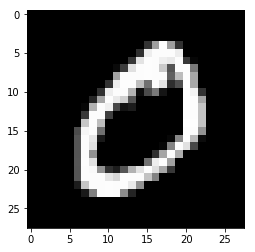

In [2]:
from tensorflow.keras.datasets.mnist import load_data
(train_X, train_y),(test_X, test_y) = load_data()

train_X = train_X/255.0
train_y = train_y/255.0

test_X = test_X/255.0
test_y = test_y/255.0


train = np.append(train_X, test_X, axis=0) #Use both Train and Testset for GAN

print(train.shape)

image = train[1]

print(image.shape)
print(image.dtype)
plt.imshow(image.reshape(28,28), cmap='gray')

print(image)

## Discriminator

In [3]:
def discriminator(X, reuse_vars=None):
    with tf.variable_scope('dis', reuse=reuse_vars):
        
        #1 Conv2d
        conv1 = tf.layers.conv2d(inputs=X, filters=32, kernel_size=[5,5], padding="same", activation=tf.nn.relu, name="conv1")

        #1 Pooling
        pool1 = tf.layers.average_pooling2d(inputs=conv1, pool_size=[2,2], strides=2, name="pool1")

        #2 Conv2d
        conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5,5], padding="same", activation=tf.nn.relu, name="conv2")

        #2 Pooling
        pool2 = tf.layers.average_pooling2d(inputs=conv2, pool_size=[2,2], strides=2, name="pool2")

        # Flatten
        flat_layer = tf.reshape(pool2, [-1, 7 * 7 * 64], name="flatten")

        # Dense
        dense = tf.layers.dense(inputs=flat_layer, units=1024, activation=tf.nn.relu, name="dense")

        # Logits
        logits = tf.layers.dense(inputs=dense, units=1, name="dense2")
        
        #output = tf.sigmoid(logits, name="sigmoid")
        
        return logits

## Generator

In [4]:
def gen(noise, reuse_vars=None):
    with tf.variable_scope("gen", reuse=reuse_vars):
        
        #1 Dense Layer
        dense = tf.layers.dense(inputs=noise, units=3136, activation=tf.nn.relu, name="dense_g")
        

        #Reshape
        reshape = tf.reshape(dense, [-1, 56, 56, 1], name="reshape")


        #1 Conv2d
        conv1 = tf.layers.conv2d(inputs=reshape, filters=50, kernel_size=[3,3], strides=2, padding="same", activation=tf.nn.relu, name="conv1")

        #BatchNormalization
        conv1_norm = tf.layers.batch_normalization(conv1, name="batch_norm1")

        #Upsample
        conv1_upsample = tf.image.resize_images(conv1_norm, (56,56))


        #2 Conv2d
        conv2 = tf.layers.conv2d(inputs=conv1_upsample, filters=25, kernel_size=[3,3], strides=2, padding="same", activation=tf.nn.relu, name="conv2")

        #BatchNormalization
        conv2_norm = tf.layers.batch_normalization(conv2, name="batch_norm2")

        #Upsample
        conv2_upsample = tf.image.resize_images(conv2_norm, (56,56))


        #2 Conv2d
        logits = tf.layers.conv2d(inputs=conv2_upsample, filters=1, kernel_size=[3,3], strides=2, padding="same", name="conv3")

        output = tf.nn.sigmoid(logits, name="sigmoid")
        
        return output

## Building the GAN

In [5]:
with tf.name_scope('input'):
    real_images = tf.placeholder(tf.float32, shape=[None, 28,28,1], name="ImagePlaceholder")
    z = tf.placeholder(tf.float32, shape=[None, 100], name = "NoisePlaceholder")

In [6]:
Gz = gen(z)

In [7]:
D_output_real = discriminator(real_images)
D_output_fake = discriminator(Gz, reuse_vars=True)

## Training the GAN

In [8]:
D_learning_rate = 0.00005
G_learning_rate = 0.00005

In [9]:
d_vars = tf.trainable_variables(scope='dis')
g_vars = tf.trainable_variables(scope='gen')

In [10]:
D_loss = tf.reduce_mean(D_output_real) - tf.reduce_mean(D_output_fake)
G_loss = -tf.reduce_mean(D_output_fake)

In [11]:
D_solver = (tf.train.RMSPropOptimizer(learning_rate=D_learning_rate)
            .minimize(-D_loss, var_list=d_vars))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=G_learning_rate)
            .minimize(G_loss, var_list=g_vars))

In [12]:
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in d_vars]

In [13]:
#tf.summary.scalar("Dx_Loss", D_real_loss)
#tf.summary.scalar("Dg_Loss", D_fake_loss)
tf.summary.scalar("D_loss", D_loss)
tf.summary.scalar("G_loss", G_loss)

tf.summary.image("Generated_Images", Gz, max_outputs=5)

<tf.Tensor 'Generated_Images:0' shape=() dtype=string>

In [14]:
import datetime

now = datetime.datetime.now()

In [15]:
BATCH_SIZE = 100

BUFFER_SIZE = 140000

EPOCHS = 1000000

In [16]:
samples = []
real = []

In [17]:
#Adding config for GPU - not using all of the GPUs Memory -> leading to crashes
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8

merged = tf.summary.merge_all()

In [18]:
from tqdm import tqdm

train = train.reshape(train.shape[0], 28, 28, 1).astype('float32')

train_dataset = tf.data.Dataset.from_tensor_slices(train).repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

iterator = train_dataset.make_one_shot_iterator()

nextbatch = iterator.get_next()

init = tf.global_variables_initializer()

  0%|                                                                                      | 0/1000000 [00:00<?, ?it/s]

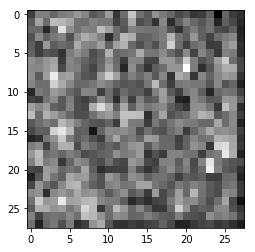

  0%|▎                                                                       | 4999/1000000 [06:40<21:11:34, 13.04it/s]

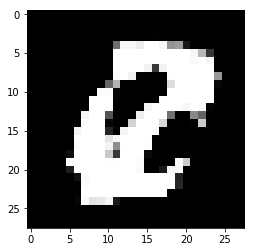

  1%|▋                                                                       | 9999/1000000 [13:02<20:40:41, 13.30it/s]

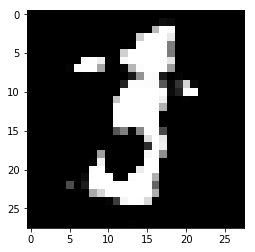

  1%|█                                                                      | 14999/1000000 [19:25<20:56:49, 13.06it/s]

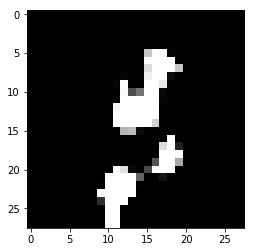

  2%|█▍                                                                     | 19999/1000000 [25:49<20:27:39, 13.30it/s]

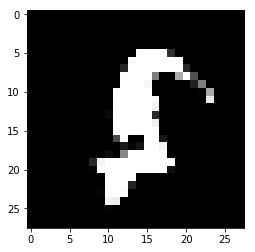

  2%|█▊                                                                     | 24999/1000000 [32:11<20:15:04, 13.37it/s]

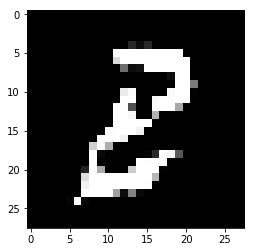

  3%|██▏                                                                    | 29999/1000000 [38:34<20:21:46, 13.23it/s]

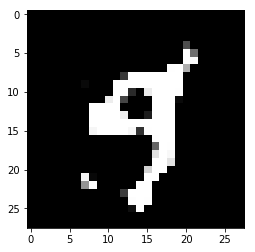

  3%|██▍                                                                    | 34999/1000000 [45:18<20:10:31, 13.29it/s]

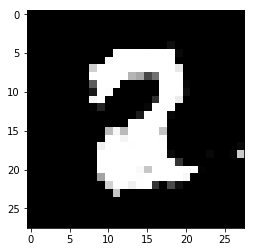

  4%|██▊                                                                    | 39999/1000000 [51:37<19:53:58, 13.40it/s]

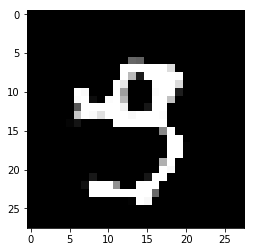

  4%|███▏                                                                   | 44999/1000000 [57:53<19:42:17, 13.46it/s]

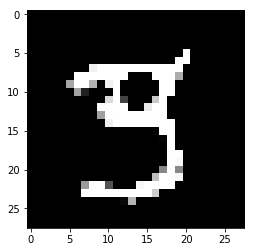

  5%|███▍                                                                 | 49999/1000000 [1:04:09<19:42:30, 13.39it/s]

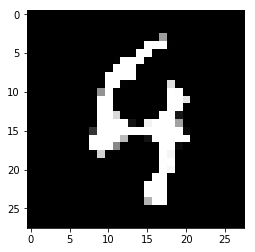

  5%|███▊                                                                 | 54999/1000000 [1:10:31<19:37:59, 13.37it/s]

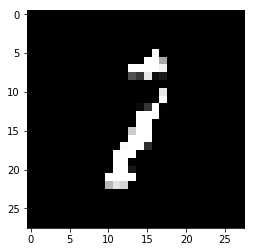

  6%|████▏                                                                | 59999/1000000 [1:16:51<19:38:04, 13.30it/s]

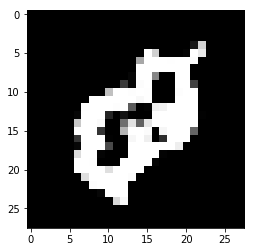

  6%|████▍                                                                | 64999/1000000 [1:23:10<19:28:36, 13.34it/s]

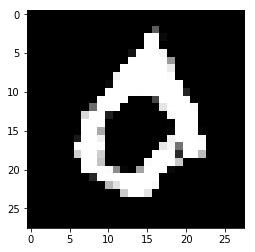

  7%|████▊                                                                | 69999/1000000 [1:29:29<19:30:44, 13.24it/s]

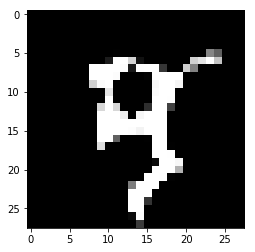

  7%|█████▏                                                               | 74999/1000000 [1:35:49<19:24:25, 13.24it/s]

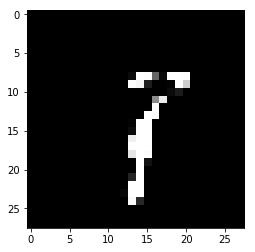

  8%|█████▌                                                               | 79999/1000000 [1:42:08<19:12:24, 13.31it/s]

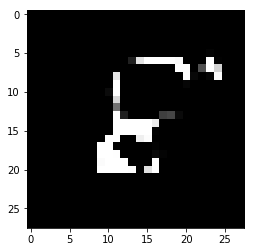

  8%|█████▊                                                               | 84999/1000000 [1:48:28<19:11:29, 13.24it/s]

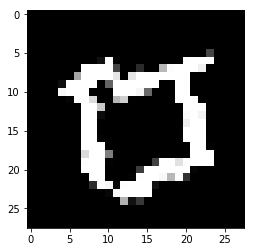

  9%|██████▏                                                              | 89999/1000000 [1:54:47<18:57:32, 13.33it/s]

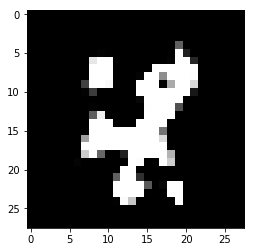

  9%|██████▌                                                              | 94999/1000000 [2:01:07<18:50:54, 13.34it/s]

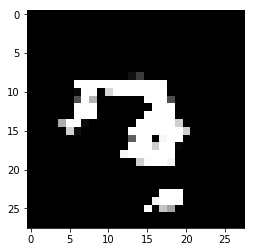

 10%|██████▉                                                              | 99999/1000000 [2:07:27<18:46:21, 13.32it/s]

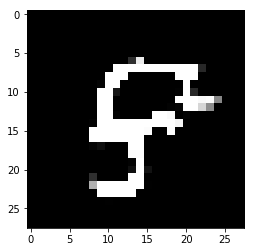

 10%|███████▏                                                            | 104999/1000000 [2:13:46<18:45:14, 13.26it/s]

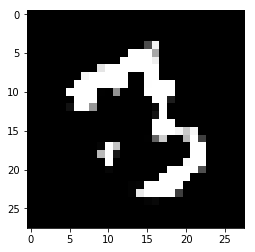

 11%|███████▍                                                            | 109999/1000000 [2:20:06<18:46:37, 13.17it/s]

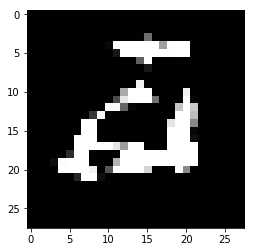

 11%|███████▊                                                            | 114999/1000000 [2:26:26<18:36:19, 13.21it/s]

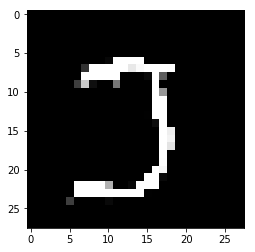

 12%|████████▏                                                           | 119999/1000000 [2:32:45<18:24:21, 13.28it/s]

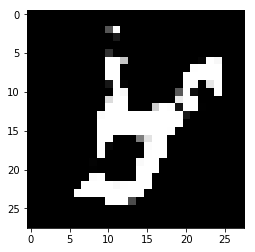

 12%|████████▍                                                           | 124999/1000000 [2:39:05<18:21:06, 13.24it/s]

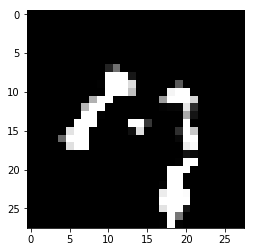

 13%|████████▊                                                           | 129999/1000000 [2:45:25<18:05:50, 13.35it/s]

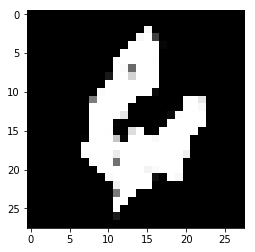

 13%|█████████▏                                                          | 134999/1000000 [2:51:44<18:01:17, 13.33it/s]

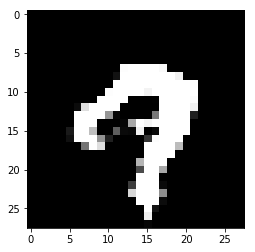

 14%|█████████▌                                                          | 139999/1000000 [2:58:04<18:00:09, 13.27it/s]

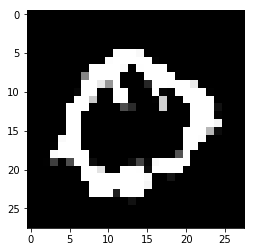

 14%|█████████▊                                                          | 144999/1000000 [3:04:24<17:53:58, 13.27it/s]

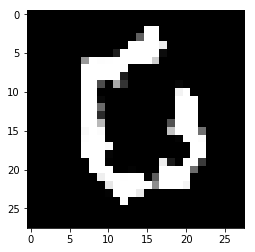

 15%|██████████▏                                                         | 149999/1000000 [3:10:44<17:47:47, 13.27it/s]

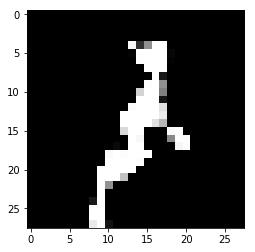

 15%|██████████▌                                                         | 154999/1000000 [3:17:03<17:38:22, 13.31it/s]

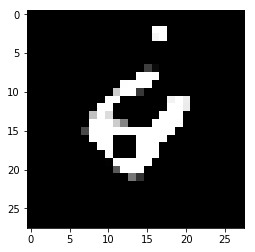

 16%|██████████▉                                                         | 159999/1000000 [3:23:23<17:45:40, 13.14it/s]

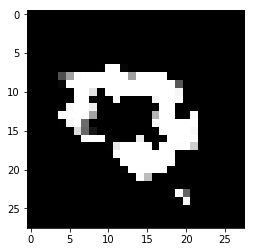

 16%|███████████▏                                                        | 164999/1000000 [3:29:45<17:25:26, 13.31it/s]

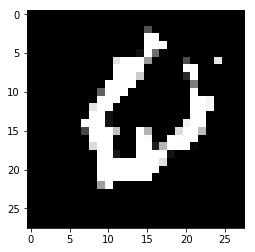

 17%|███████████▌                                                        | 169999/1000000 [3:36:04<17:17:50, 13.33it/s]

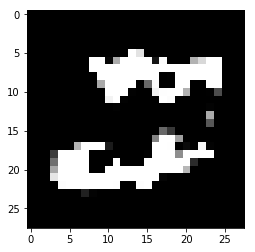

 17%|███████████▉                                                        | 174999/1000000 [3:42:24<17:07:18, 13.38it/s]

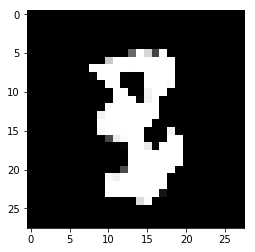

 18%|████████████▏                                                       | 179999/1000000 [3:48:44<17:10:05, 13.27it/s]

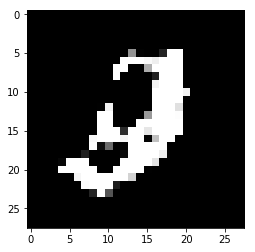

 18%|████████████▌                                                       | 184999/1000000 [3:55:03<16:57:16, 13.35it/s]

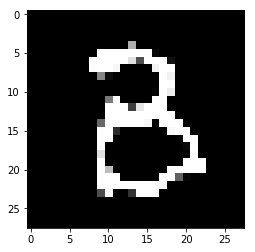

 19%|████████████▉                                                       | 189999/1000000 [4:01:23<16:58:08, 13.26it/s]

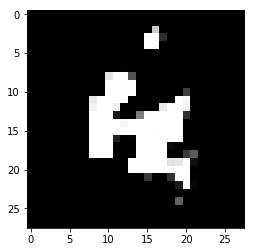

 19%|█████████████▎                                                      | 194999/1000000 [4:07:43<16:46:02, 13.34it/s]

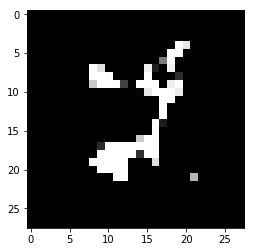

 20%|█████████████▌                                                      | 199999/1000000 [4:14:02<16:36:02, 13.39it/s]

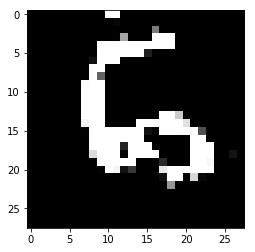

 20%|█████████████▉                                                      | 204999/1000000 [4:20:22<16:36:45, 13.29it/s]

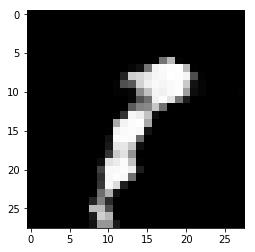

 21%|██████████████▎                                                     | 209999/1000000 [4:26:42<16:37:03, 13.21it/s]

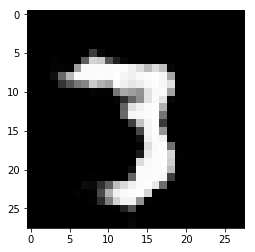

 21%|██████████████▌                                                     | 214999/1000000 [4:33:02<16:35:02, 13.15it/s]

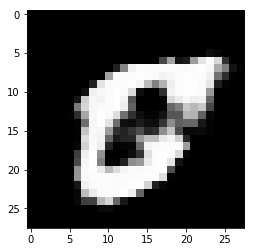

 22%|██████████████▉                                                     | 219999/1000000 [4:39:22<16:17:44, 13.30it/s]

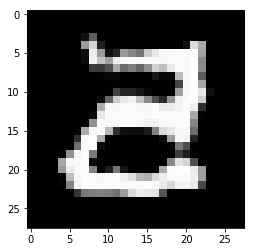

 22%|███████████████▎                                                    | 224999/1000000 [4:45:42<16:11:44, 13.29it/s]

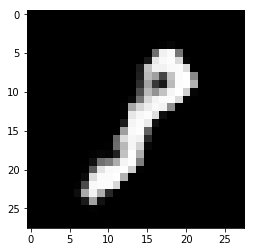

 23%|███████████████▋                                                    | 229999/1000000 [4:52:02<16:02:52, 13.33it/s]

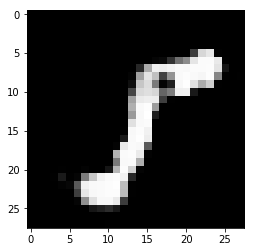

 23%|███████████████▉                                                    | 234999/1000000 [4:58:22<16:01:54, 13.26it/s]

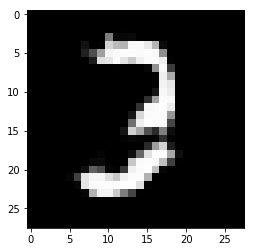

 24%|████████████████▎                                                   | 239999/1000000 [5:04:42<15:50:58, 13.32it/s]

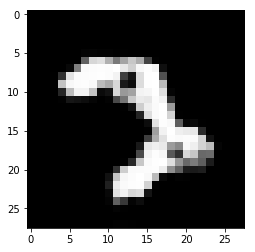

 24%|████████████████▋                                                   | 244999/1000000 [5:11:02<15:44:12, 13.33it/s]

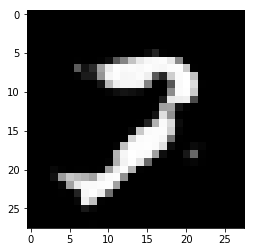

 25%|████████████████▉                                                   | 249999/1000000 [5:17:22<15:37:52, 13.33it/s]

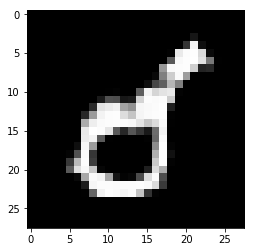

 25%|█████████████████▎                                                  | 254999/1000000 [5:23:42<15:30:53, 13.34it/s]

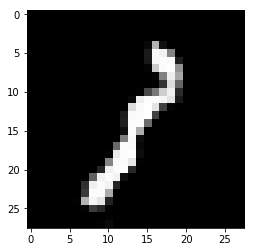

 26%|█████████████████▋                                                  | 259999/1000000 [5:30:02<15:25:55, 13.32it/s]

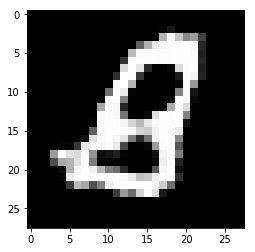

 26%|██████████████████                                                  | 264999/1000000 [5:36:22<15:24:31, 13.25it/s]

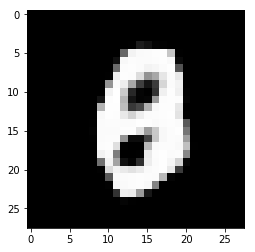

 27%|██████████████████▎                                                 | 269999/1000000 [5:42:43<15:20:58, 13.21it/s]

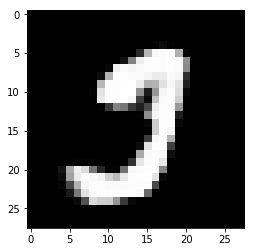

 27%|██████████████████▋                                                 | 274999/1000000 [5:49:03<15:07:00, 13.32it/s]

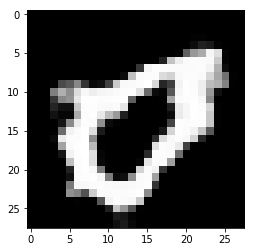

 28%|███████████████████                                                 | 279999/1000000 [5:55:23<15:02:13, 13.30it/s]

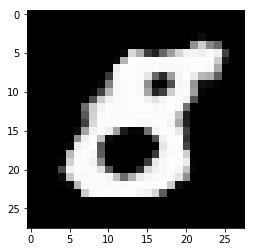

 28%|███████████████████▍                                                | 284999/1000000 [6:01:43<15:05:58, 13.15it/s]

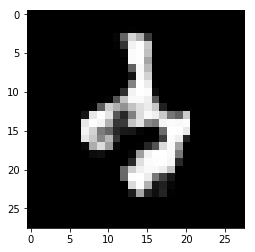

 29%|███████████████████▋                                                | 289999/1000000 [6:08:03<14:47:48, 13.33it/s]

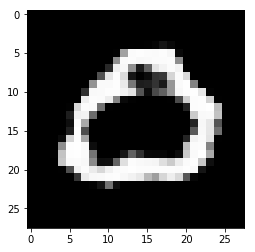

 29%|████████████████████                                                | 294999/1000000 [6:14:23<14:41:49, 13.32it/s]

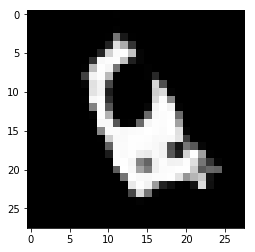

 30%|████████████████████▍                                               | 299999/1000000 [6:20:43<14:40:52, 13.24it/s]

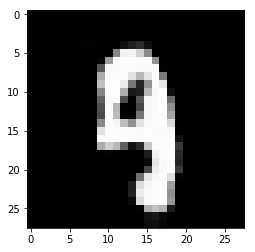

 30%|████████████████████▋                                               | 304999/1000000 [6:27:03<14:36:45, 13.21it/s]

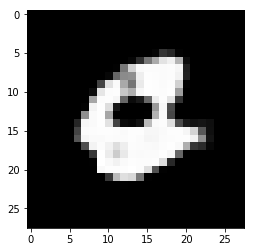

 31%|█████████████████████                                               | 309999/1000000 [6:33:23<14:22:33, 13.33it/s]

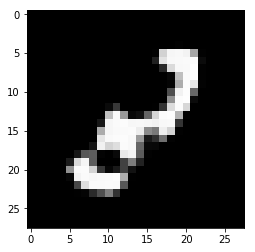

 31%|█████████████████████▍                                              | 314999/1000000 [6:39:43<14:21:46, 13.25it/s]

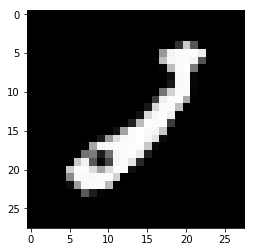

 32%|█████████████████████▊                                              | 319999/1000000 [6:46:03<14:17:52, 13.21it/s]

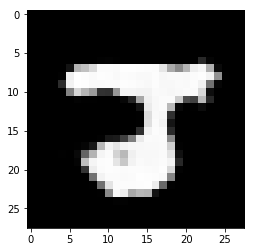

 32%|██████████████████████                                              | 324999/1000000 [6:52:23<14:08:50, 13.25it/s]

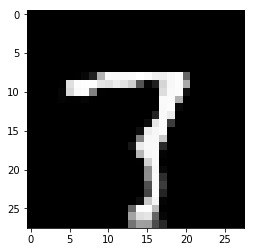

 33%|██████████████████████▍                                             | 329999/1000000 [6:58:43<13:56:58, 13.34it/s]

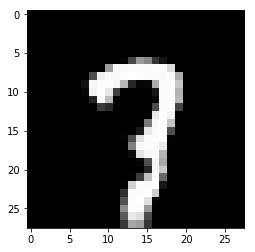

 33%|██████████████████████▊                                             | 334999/1000000 [7:05:03<13:51:42, 13.33it/s]

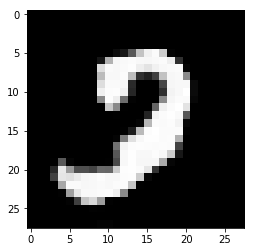

 34%|███████████████████████                                             | 339999/1000000 [7:11:24<13:47:46, 13.29it/s]

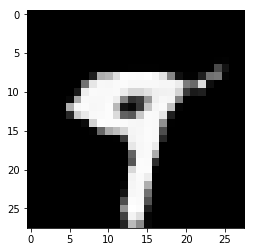

 34%|███████████████████████▍                                            | 344999/1000000 [7:17:44<13:45:06, 13.23it/s]

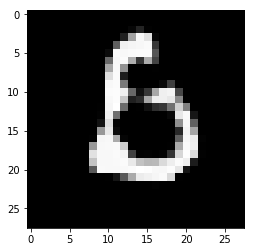

 35%|███████████████████████▊                                            | 349999/1000000 [7:24:04<13:29:46, 13.38it/s]

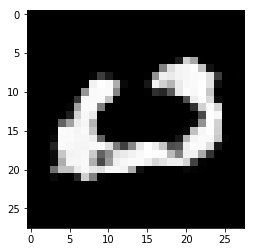

 35%|████████████████████████▏                                           | 354999/1000000 [7:30:25<13:32:15, 13.23it/s]

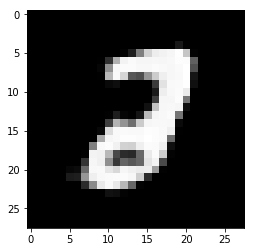

 36%|████████████████████████▍                                           | 359999/1000000 [7:36:45<13:25:57, 13.23it/s]

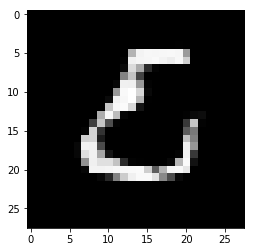

 36%|████████████████████████▊                                           | 364999/1000000 [7:43:05<13:20:05, 13.23it/s]

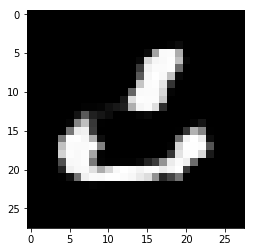

 37%|█████████████████████████▏                                          | 369999/1000000 [7:49:29<14:25:58, 12.13it/s]

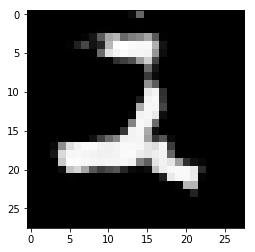

 37%|█████████████████████████▍                                          | 374999/1000000 [7:55:57<13:28:33, 12.88it/s]

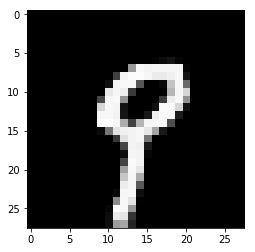

 38%|█████████████████████████▊                                          | 379999/1000000 [8:02:21<13:00:57, 13.23it/s]

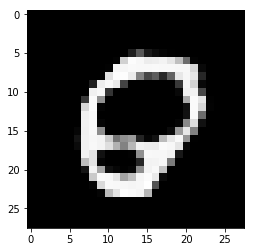

 38%|██████████████████████████▏                                         | 384999/1000000 [8:08:42<12:54:38, 13.23it/s]

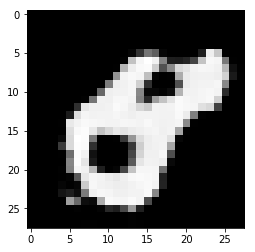

 39%|██████████████████████████▌                                         | 389999/1000000 [8:15:03<12:39:31, 13.39it/s]

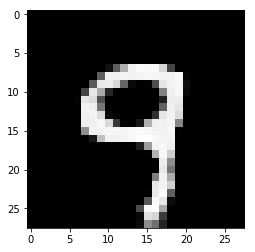

 39%|██████████████████████████▊                                         | 394999/1000000 [8:21:23<12:48:47, 13.12it/s]

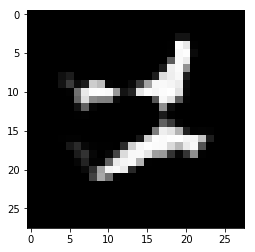

 40%|███████████████████████████▏                                        | 399999/1000000 [8:27:44<12:30:39, 13.32it/s]

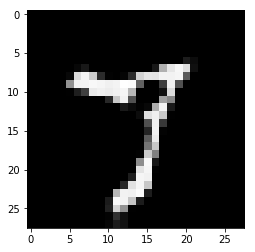

 40%|███████████████████████████▌                                        | 404999/1000000 [8:34:04<12:23:56, 13.33it/s]

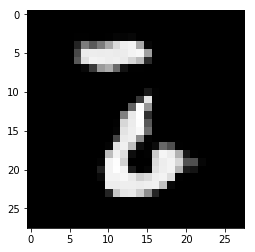

 41%|███████████████████████████▉                                        | 409999/1000000 [8:40:24<12:18:02, 13.32it/s]

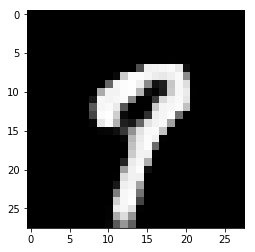

 41%|████████████████████████████▏                                       | 414999/1000000 [8:46:44<12:12:06, 13.32it/s]

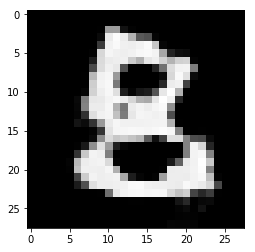

 42%|████████████████████████████▌                                       | 419999/1000000 [8:53:04<12:06:52, 13.30it/s]

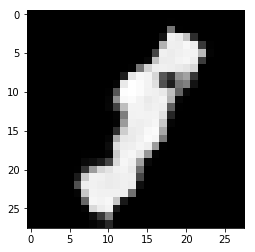

 42%|████████████████████████████▉                                       | 424999/1000000 [8:59:24<12:00:28, 13.30it/s]

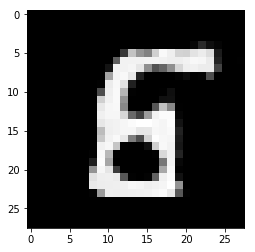

 43%|█████████████████████████████▏                                      | 429999/1000000 [9:05:44<11:49:30, 13.39it/s]

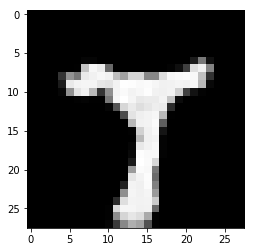

 43%|█████████████████████████████▌                                      | 434999/1000000 [9:12:04<11:47:01, 13.32it/s]

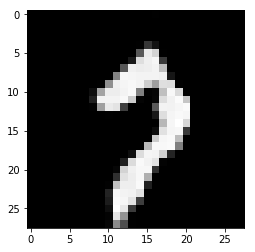

 44%|█████████████████████████████▉                                      | 439999/1000000 [9:18:24<11:45:37, 13.23it/s]

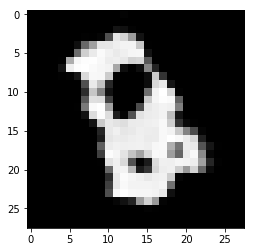

 44%|██████████████████████████████▎                                     | 444999/1000000 [9:24:44<11:38:20, 13.25it/s]

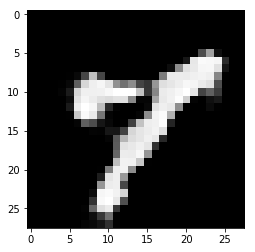

 45%|██████████████████████████████▌                                     | 449999/1000000 [9:31:04<11:32:23, 13.24it/s]

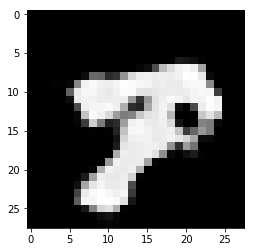

 45%|██████████████████████████████▉                                     | 454999/1000000 [9:37:25<11:20:46, 13.34it/s]

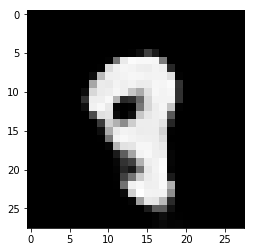

 46%|███████████████████████████████▎                                    | 459999/1000000 [9:43:45<11:16:35, 13.30it/s]

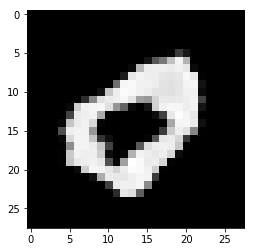

 46%|███████████████████████████████▌                                    | 464999/1000000 [9:50:06<11:15:00, 13.21it/s]

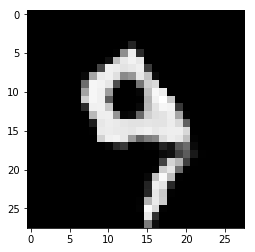

 47%|███████████████████████████████▉                                    | 469999/1000000 [9:56:26<11:05:21, 13.28it/s]

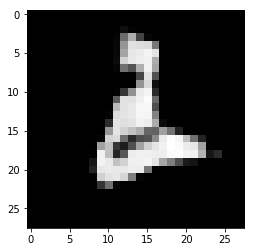

 47%|███████████████████████████████▊                                   | 474999/1000000 [10:02:46<10:59:32, 13.27it/s]

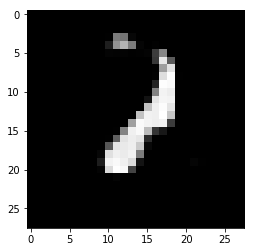

 48%|████████████████████████████████▏                                  | 479999/1000000 [10:09:06<10:51:05, 13.31it/s]

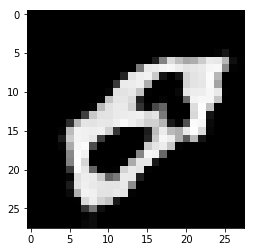

 48%|████████████████████████████████▍                                  | 484999/1000000 [10:15:26<10:43:13, 13.34it/s]

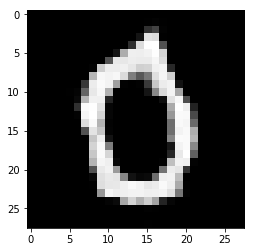

 49%|████████████████████████████████▊                                  | 489999/1000000 [10:21:46<10:39:22, 13.29it/s]

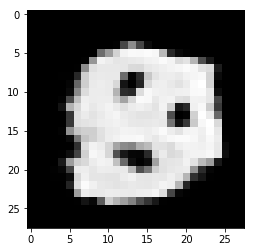

 49%|█████████████████████████████████▏                                 | 494999/1000000 [10:28:10<10:36:20, 13.23it/s]

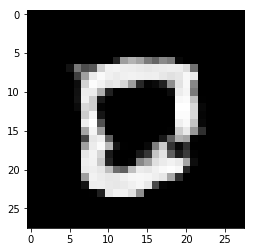

 50%|█████████████████████████████████▍                                 | 499999/1000000 [10:34:32<10:24:16, 13.35it/s]

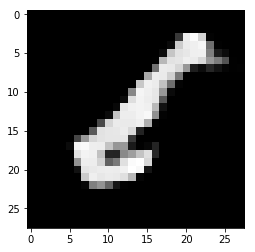

 50%|█████████████████████████████████▊                                 | 504999/1000000 [10:40:53<10:20:40, 13.29it/s]

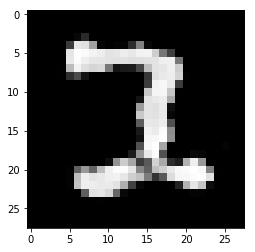

 51%|██████████████████████████████████▏                                | 509999/1000000 [10:47:15<10:15:17, 13.27it/s]

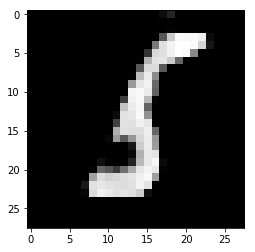

 51%|██████████████████████████████████▌                                | 514999/1000000 [10:53:34<10:07:50, 13.30it/s]

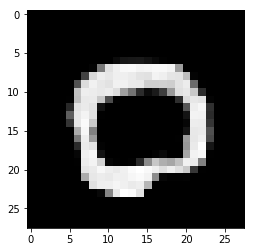

 52%|███████████████████████████████████▎                                | 519999/1000000 [10:59:52<9:57:17, 13.39it/s]

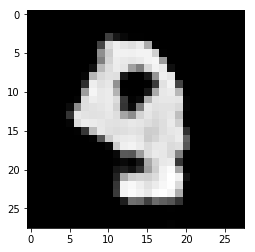

 52%|███████████████████████████████████▋                                | 524999/1000000 [11:06:10<9:51:09, 13.39it/s]

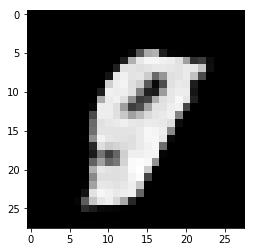

 53%|████████████████████████████████████                                | 529999/1000000 [11:12:28<9:49:20, 13.29it/s]

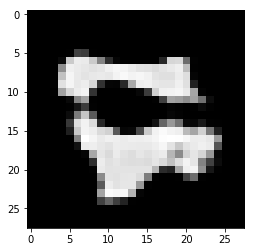

 53%|████████████████████████████████████▍                               | 534999/1000000 [11:18:47<9:41:13, 13.33it/s]

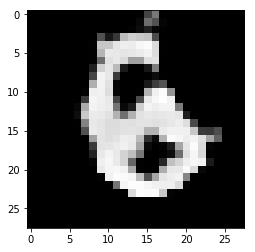

 54%|████████████████████████████████████▋                               | 539999/1000000 [11:25:05<9:32:30, 13.39it/s]

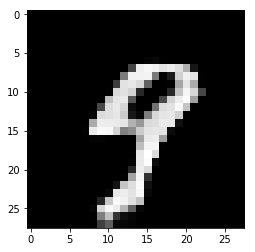

 54%|█████████████████████████████████████                               | 544999/1000000 [11:31:23<9:30:12, 13.30it/s]

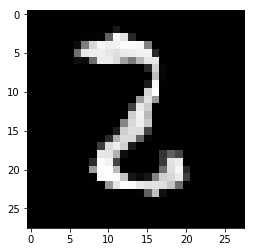

 55%|█████████████████████████████████████▍                              | 549999/1000000 [11:37:41<9:23:14, 13.32it/s]

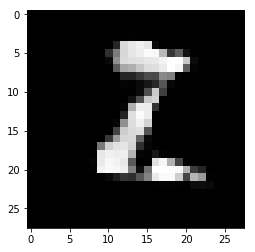

 55%|█████████████████████████████████████▋                              | 554999/1000000 [11:43:59<9:13:04, 13.41it/s]

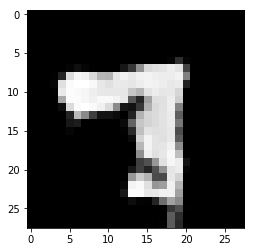

 56%|██████████████████████████████████████                              | 559999/1000000 [11:50:18<9:09:53, 13.34it/s]

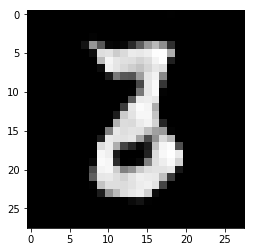

 56%|██████████████████████████████████████▍                             | 564999/1000000 [11:56:37<9:05:57, 13.28it/s]

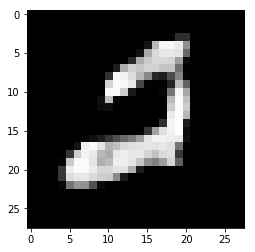

 57%|██████████████████████████████████████▊                             | 569999/1000000 [12:02:55<9:04:20, 13.17it/s]

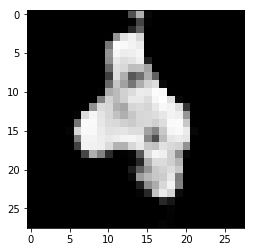

 57%|███████████████████████████████████████                             | 574999/1000000 [12:09:15<8:47:18, 13.43it/s]

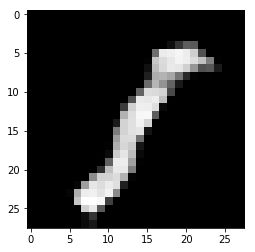

 58%|███████████████████████████████████████▍                            | 579999/1000000 [12:15:33<8:45:30, 13.32it/s]

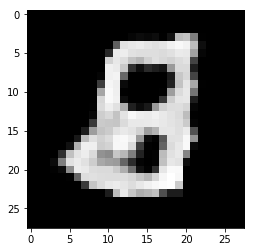

 58%|███████████████████████████████████████▊                            | 584999/1000000 [12:21:52<8:37:00, 13.38it/s]

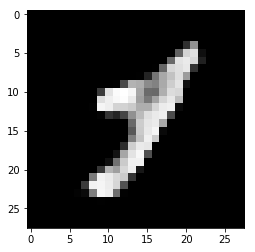

 59%|████████████████████████████████████████                            | 589999/1000000 [12:28:11<8:30:35, 13.38it/s]

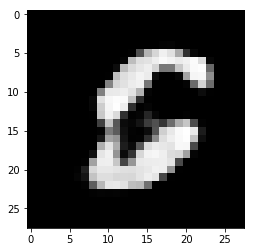

 59%|████████████████████████████████████████▍                           | 594999/1000000 [12:34:30<8:26:38, 13.32it/s]

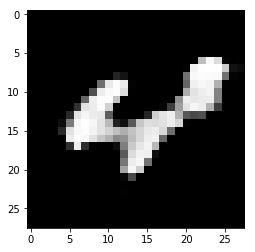

 60%|████████████████████████████████████████▊                           | 599999/1000000 [12:40:49<8:16:07, 13.44it/s]

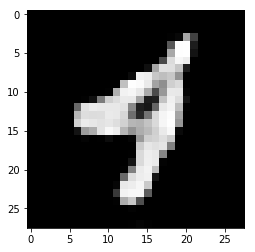

 60%|█████████████████████████████████████████▏                          | 604999/1000000 [12:47:07<8:11:25, 13.40it/s]

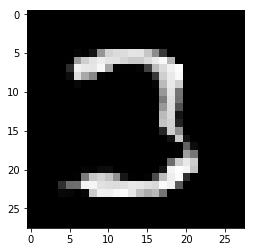

 61%|█████████████████████████████████████████▍                          | 609999/1000000 [12:53:26<8:11:45, 13.22it/s]

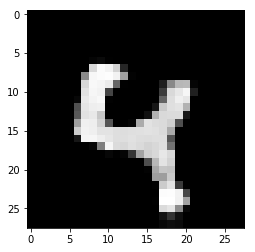

 61%|█████████████████████████████████████████▊                          | 614999/1000000 [12:59:44<7:59:44, 13.38it/s]

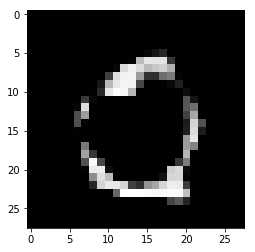

 62%|██████████████████████████████████████████▏                         | 619999/1000000 [13:06:03<7:52:38, 13.40it/s]

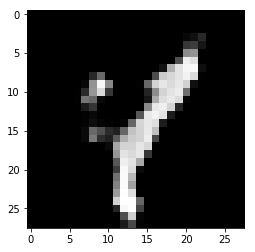

 62%|██████████████████████████████████████████▍                         | 624999/1000000 [13:12:21<7:46:08, 13.41it/s]

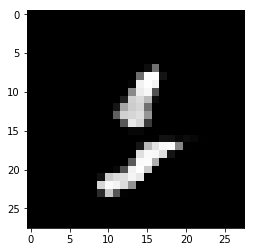

 63%|██████████████████████████████████████████▊                         | 629999/1000000 [13:18:40<7:39:00, 13.43it/s]

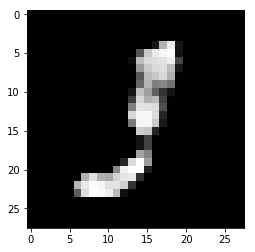

 63%|███████████████████████████████████████████▏                        | 634999/1000000 [13:24:58<7:34:31, 13.38it/s]

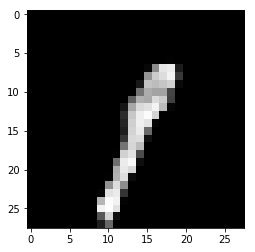

 64%|███████████████████████████████████████████▌                        | 639999/1000000 [13:31:21<7:30:00, 13.33it/s]

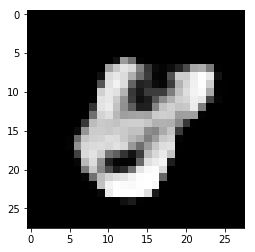

 64%|███████████████████████████████████████████▊                        | 644999/1000000 [13:37:39<7:22:34, 13.37it/s]

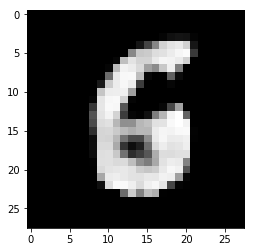

 65%|████████████████████████████████████████████▏                       | 649999/1000000 [13:43:57<7:13:53, 13.44it/s]

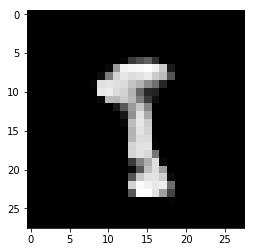

 65%|████████████████████████████████████████████▌                       | 654999/1000000 [13:50:15<7:12:40, 13.29it/s]

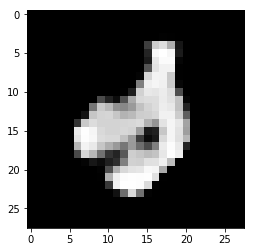

 66%|████████████████████████████████████████████▉                       | 659999/1000000 [13:56:34<7:02:58, 13.40it/s]

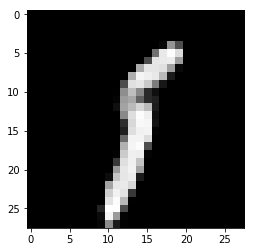

 66%|█████████████████████████████████████████████▏                      | 664999/1000000 [14:02:52<6:56:26, 13.41it/s]

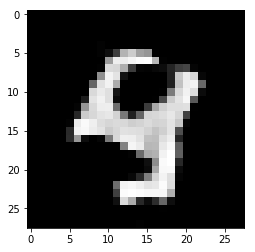

 67%|█████████████████████████████████████████████▌                      | 669999/1000000 [14:09:10<6:51:56, 13.35it/s]

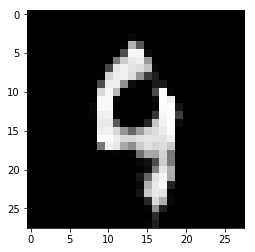

 67%|█████████████████████████████████████████████▉                      | 674999/1000000 [14:15:28<6:48:23, 13.26it/s]

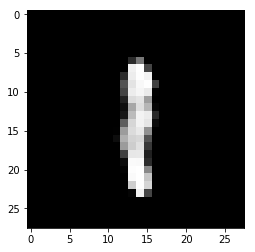

 68%|██████████████████████████████████████████████▏                     | 679999/1000000 [14:21:47<6:39:39, 13.34it/s]

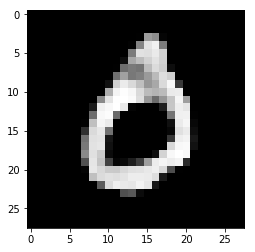

 68%|██████████████████████████████████████████████▌                     | 684999/1000000 [14:28:05<6:33:11, 13.35it/s]

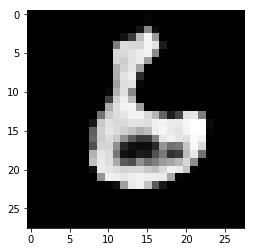

 69%|██████████████████████████████████████████████▉                     | 689999/1000000 [14:34:24<6:28:31, 13.30it/s]

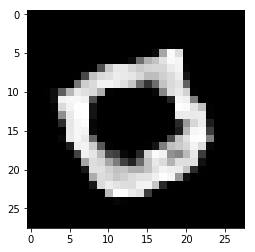

 69%|███████████████████████████████████████████████▎                    | 694999/1000000 [14:40:42<6:20:35, 13.36it/s]

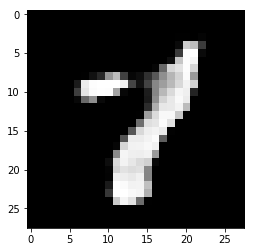

 70%|███████████████████████████████████████████████▌                    | 699999/1000000 [14:47:00<6:16:25, 13.28it/s]

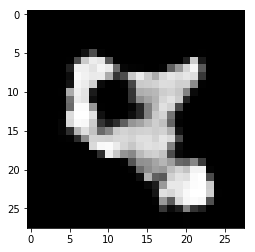

 70%|███████████████████████████████████████████████▉                    | 704999/1000000 [14:53:18<6:06:35, 13.41it/s]

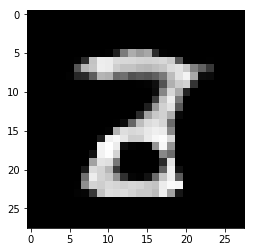

 71%|████████████████████████████████████████████████▎                   | 709999/1000000 [14:59:37<6:01:54, 13.36it/s]

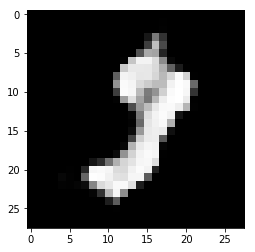

 71%|████████████████████████████████████████████████▌                   | 714999/1000000 [15:05:55<5:55:04, 13.38it/s]

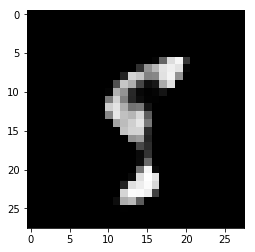

 72%|████████████████████████████████████████████████▉                   | 719999/1000000 [15:12:13<5:50:16, 13.32it/s]

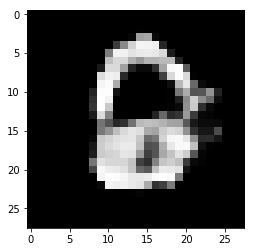

 72%|█████████████████████████████████████████████████▎                  | 724999/1000000 [15:18:31<5:44:23, 13.31it/s]

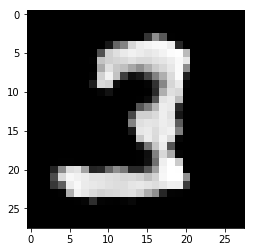

 73%|█████████████████████████████████████████████████▋                  | 729999/1000000 [15:24:50<5:38:07, 13.31it/s]

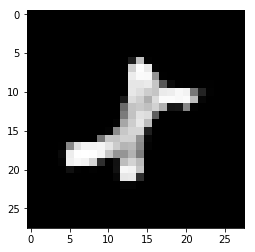

 73%|█████████████████████████████████████████████████▉                  | 734999/1000000 [15:31:10<5:33:15, 13.25it/s]

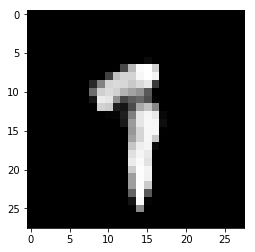

 74%|██████████████████████████████████████████████████▎                 | 739999/1000000 [15:37:29<5:25:03, 13.33it/s]

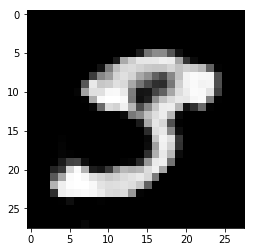

 74%|██████████████████████████████████████████████████▋                 | 744999/1000000 [15:43:49<5:19:46, 13.29it/s]

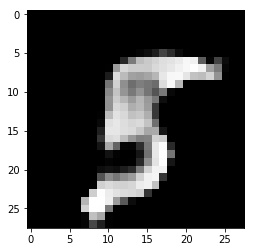

 75%|██████████████████████████████████████████████████▉                 | 749999/1000000 [15:50:09<5:14:13, 13.26it/s]

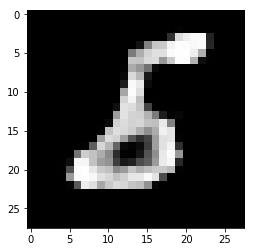

 75%|███████████████████████████████████████████████████▎                | 754999/1000000 [15:56:29<5:05:27, 13.37it/s]

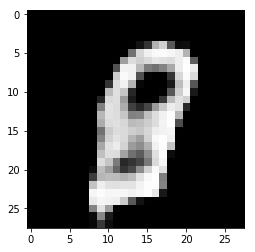

 76%|███████████████████████████████████████████████████▋                | 759999/1000000 [16:02:49<5:02:43, 13.21it/s]

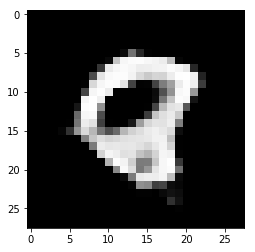

 76%|████████████████████████████████████████████████████                | 764999/1000000 [16:09:08<4:53:23, 13.35it/s]

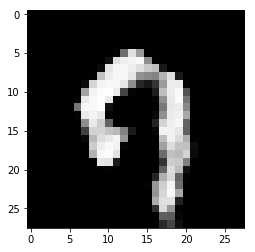

 77%|████████████████████████████████████████████████████▎               | 769999/1000000 [16:15:26<4:51:53, 13.13it/s]

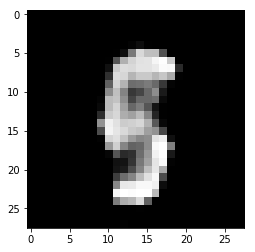

 77%|████████████████████████████████████████████████████▋               | 774999/1000000 [16:21:44<4:41:11, 13.34it/s]

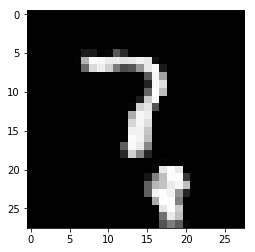

 78%|█████████████████████████████████████████████████████               | 779999/1000000 [16:28:03<4:36:47, 13.25it/s]

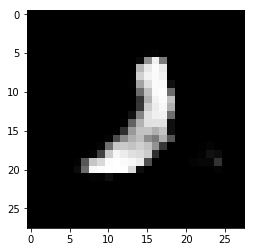

 78%|█████████████████████████████████████████████████████▍              | 784999/1000000 [16:34:21<4:28:58, 13.32it/s]

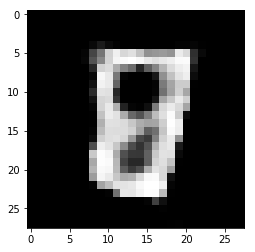

 79%|█████████████████████████████████████████████████████▋              | 789999/1000000 [16:40:39<4:21:20, 13.39it/s]

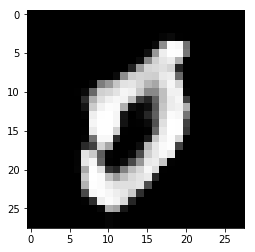

 79%|██████████████████████████████████████████████████████              | 794999/1000000 [16:46:58<4:15:45, 13.36it/s]

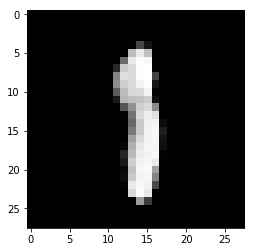

 80%|██████████████████████████████████████████████████████▍             | 799999/1000000 [16:53:16<4:09:41, 13.35it/s]

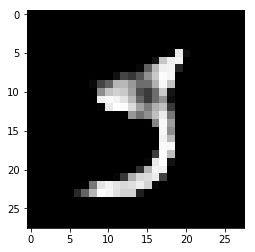

 80%|██████████████████████████████████████████████████████▋             | 804999/1000000 [16:59:35<4:04:45, 13.28it/s]

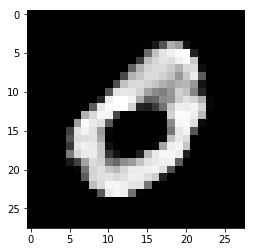

 81%|███████████████████████████████████████████████████████             | 809999/1000000 [17:05:53<3:58:37, 13.27it/s]

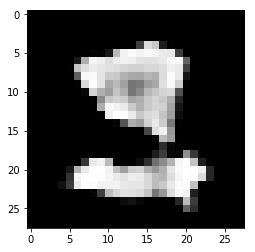

 81%|███████████████████████████████████████████████████████▍            | 814999/1000000 [17:12:11<3:50:56, 13.35it/s]

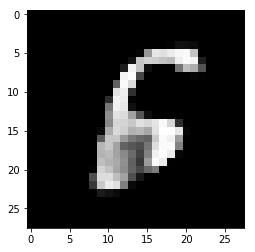

 82%|███████████████████████████████████████████████████████▊            | 819999/1000000 [17:18:29<3:43:31, 13.42it/s]

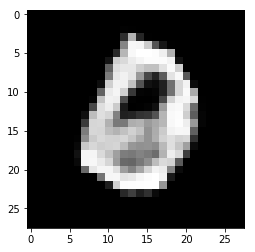

 82%|████████████████████████████████████████████████████████            | 824999/1000000 [17:24:51<3:38:19, 13.36it/s]

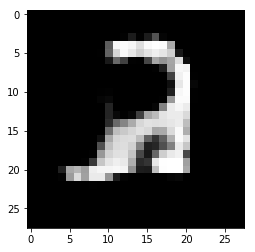

 83%|████████████████████████████████████████████████████████▍           | 829999/1000000 [17:31:10<3:32:56, 13.31it/s]

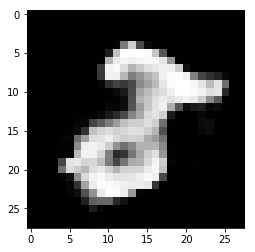

 83%|████████████████████████████████████████████████████████▊           | 834999/1000000 [17:37:29<3:25:16, 13.40it/s]

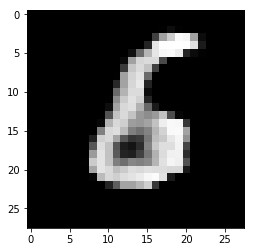

 84%|█████████████████████████████████████████████████████████           | 839999/1000000 [17:43:47<3:19:51, 13.34it/s]

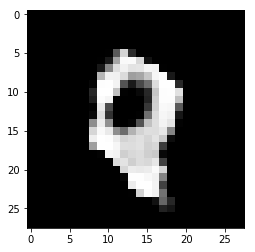

 84%|█████████████████████████████████████████████████████████▍          | 844999/1000000 [17:50:06<3:13:23, 13.36it/s]

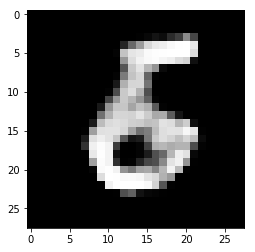

 85%|█████████████████████████████████████████████████████████▊          | 849999/1000000 [17:56:25<3:07:50, 13.31it/s]

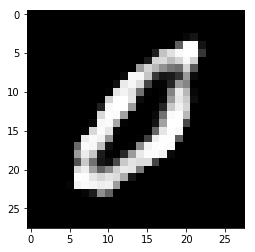

 85%|██████████████████████████████████████████████████████████▏         | 854999/1000000 [18:02:44<3:01:32, 13.31it/s]

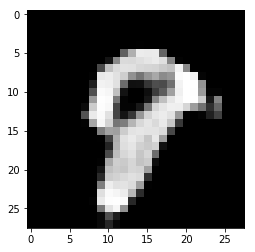

 86%|██████████████████████████████████████████████████████████▍         | 859999/1000000 [18:09:02<2:55:18, 13.31it/s]

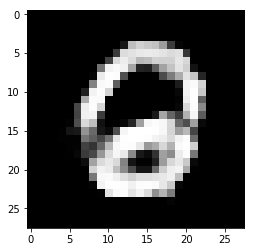

 86%|██████████████████████████████████████████████████████████▊         | 864999/1000000 [18:15:21<2:48:41, 13.34it/s]

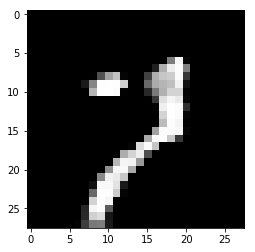

 87%|███████████████████████████████████████████████████████████▏        | 869999/1000000 [18:21:40<2:42:40, 13.32it/s]

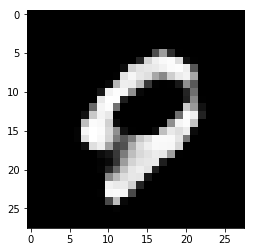

 87%|███████████████████████████████████████████████████████████▍        | 874999/1000000 [18:27:58<2:37:08, 13.26it/s]

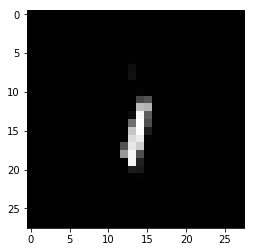

 88%|███████████████████████████████████████████████████████████▊        | 879999/1000000 [18:34:17<2:30:03, 13.33it/s]

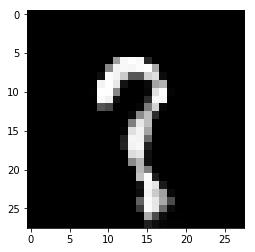

 88%|████████████████████████████████████████████████████████████▏       | 884999/1000000 [18:40:36<2:23:07, 13.39it/s]

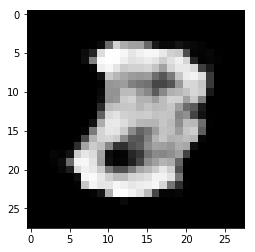

 89%|████████████████████████████████████████████████████████████▌       | 889999/1000000 [18:46:54<2:17:44, 13.31it/s]

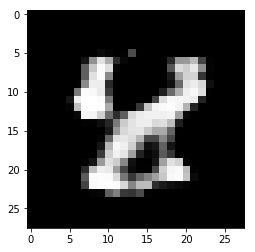

 89%|████████████████████████████████████████████████████████████▊       | 894999/1000000 [18:53:13<2:10:20, 13.43it/s]

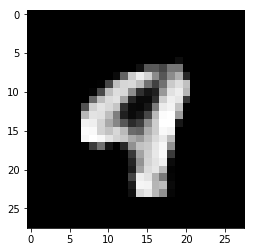

 90%|█████████████████████████████████████████████████████████████▏      | 899999/1000000 [18:59:31<2:04:03, 13.43it/s]

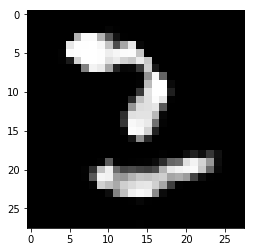

 90%|█████████████████████████████████████████████████████████████▌      | 904999/1000000 [19:05:49<1:57:47, 13.44it/s]

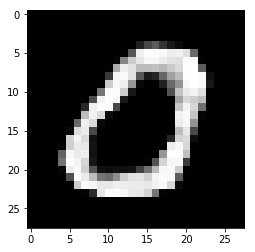

 91%|█████████████████████████████████████████████████████████████▉      | 909999/1000000 [19:12:08<1:52:40, 13.31it/s]

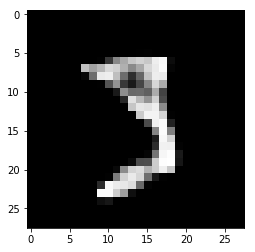

 91%|██████████████████████████████████████████████████████████████▏     | 914999/1000000 [19:18:26<1:47:38, 13.16it/s]

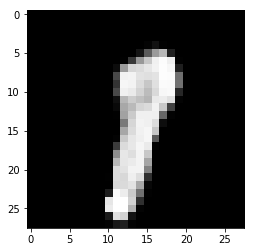

 92%|██████████████████████████████████████████████████████████████▌     | 919999/1000000 [19:24:45<1:39:21, 13.42it/s]

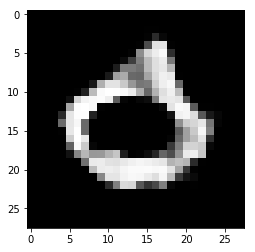

 92%|██████████████████████████████████████████████████████████████▉     | 924999/1000000 [19:31:03<1:34:11, 13.27it/s]

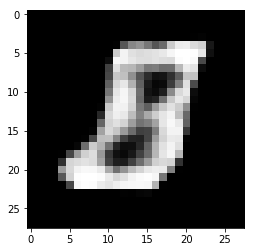

 93%|███████████████████████████████████████████████████████████████▏    | 929999/1000000 [19:37:23<1:26:41, 13.46it/s]

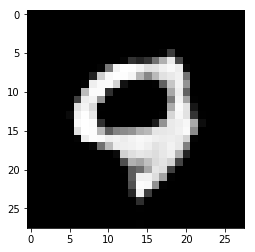

 93%|███████████████████████████████████████████████████████████████▌    | 934999/1000000 [19:43:43<1:21:08, 13.35it/s]

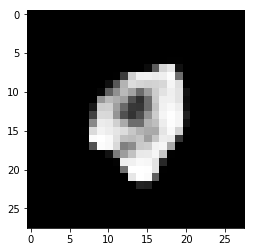

 94%|███████████████████████████████████████████████████████████████▉    | 939999/1000000 [19:50:01<1:15:04, 13.32it/s]

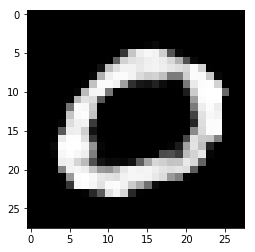

 94%|████████████████████████████████████████████████████████████████▎   | 944999/1000000 [19:56:20<1:08:34, 13.37it/s]

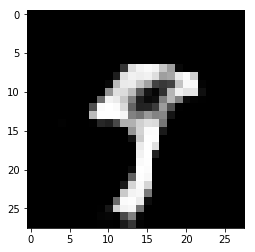

 95%|████████████████████████████████████████████████████████████████▌   | 949999/1000000 [20:02:39<1:02:52, 13.25it/s]

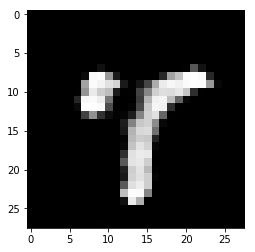

 95%|██████████████████████████████████████████████████████████████████▊   | 954999/1000000 [20:08:57<56:12, 13.34it/s]

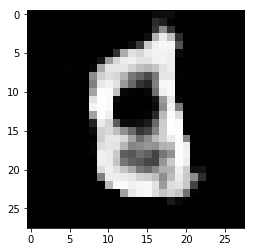

 96%|███████████████████████████████████████████████████████████████████▏  | 959999/1000000 [20:15:17<49:42, 13.41it/s]

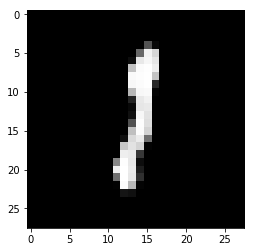

 96%|███████████████████████████████████████████████████████████████████▌  | 964999/1000000 [20:21:36<43:45, 13.33it/s]

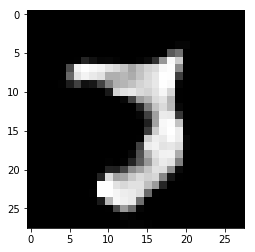

 97%|███████████████████████████████████████████████████████████████████▉  | 969999/1000000 [20:27:55<37:12, 13.44it/s]

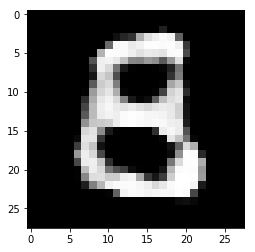

 97%|████████████████████████████████████████████████████████████████████▏ | 974999/1000000 [20:34:14<31:19, 13.30it/s]

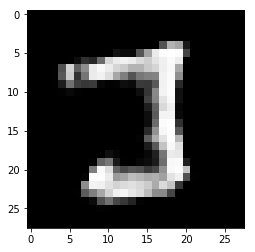

 98%|████████████████████████████████████████████████████████████████████▌ | 979999/1000000 [20:40:33<24:51, 13.41it/s]

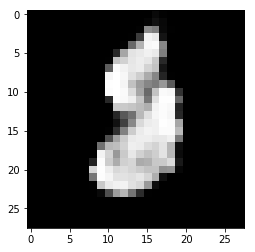

 98%|████████████████████████████████████████████████████████████████████▉ | 984999/1000000 [20:46:51<18:44, 13.35it/s]

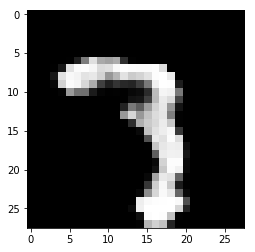

 99%|█████████████████████████████████████████████████████████████████████▎| 989999/1000000 [20:53:10<12:27, 13.38it/s]

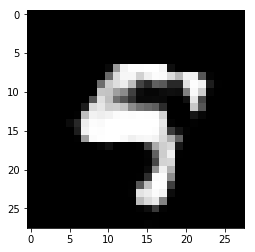

 99%|█████████████████████████████████████████████████████████████████████▋| 994999/1000000 [20:59:29<06:17, 13.25it/s]

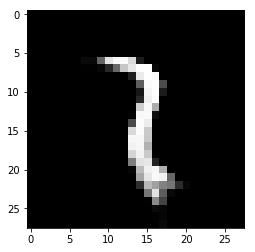

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [21:05:48<00:00, 13.17it/s]


In [20]:
with tf.Session(config=config) as sess:
    sess.run(init)
    
    writer = tf.summary.FileWriter('./tensorboard-wgan/{0}_WGAN'.format(now.strftime("%Y_%m_%d-%H-%M")), sess.graph)

    for epoch in tqdm(range(EPOCHS)):
        batch_z = np.random.uniform(-1,1,size=(BATCH_SIZE,100))

        # We train the Discriminator 5 times as much as the generator. Therefore a for loop with the range of 5
        for _ in range(5):
            batch_images = sess.run(nextbatch)            
            D_summary, _, discrloss, _ = sess.run([merged, D_solver, D_loss, clip_D], feed_dict={real_images:batch_images, z:batch_z})

        genloss, _ = sess.run([G_loss, G_solver], feed_dict={z:batch_z})

        if (epoch % 10 == 0):{
            # SUMMARIES
            writer.add_summary(D_summary, epoch)     
            
        }

        if (epoch%5000 == 0):
            sample_z = np.random.uniform(-1,1,size=(1,100))
            
            gen_sample = sess.run(gen(z, reuse_vars=True), feed_dict={z: sample_z})
        
            samples.append(gen_sample)
            
            plt.imshow(gen_sample.reshape(28,28), cmap="gray")
            plt.show()
        

# Conclusions

With the WGAN Setup we were able to create a much more stable GAN that generates images. It also tried generating different Digits. But with the WGAN we can see, that the results aren't as good for a single digit. On the other hand, it generalizes much better, since it learns the concept of a digit rather than learning how to create a single digit in a perfect way.

### Discriminator Loss: 
![](WGAN-D_loss.svg) 

### Generator Loss:

![](WGAN-G_loss.svg) 


By looking at the loss curves for the discriminator and generator, we can clearly see that after around 200k Epochs the losses have a much higher amplitude. At this moment the generated images have blurred edges as seen below.

### Image before 200.000 Epoch

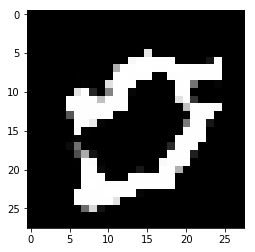

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.imshow(mpimg.imread('wgan-before200k.png'), cmap="gray")
plt.show()

### Image after 200.000 Epoch

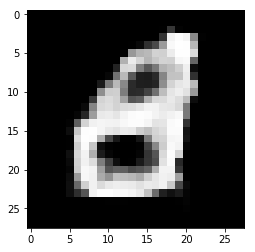

In [2]:
plt.imshow(mpimg.imread('wgan-after200k.png'), cmap="gray")
plt.show()

We can clearly see that the edges of the digits are suddenly blurred and give a much more realistic look and feel.

In the Loss Graphs we can also see, that during the first 200.000 Epochs, the Discriminator Loss falls from a high value until and it smooths out at around 0.06. The curve is realtively smooth.  
After the 200.000 Epoch mark, the discriminator jumps much more around this value, but stays around it.


The Generator on the other side has a larger absolute value until the 200.000 Epoch mark. After this mark, it suddenly jumps up and has a lower absolute value than before and jumps around -0.5 and +1.

This jumping behaviour can be interpreted that the Generator and Discriminator are learning from each other. 

# Further experiments
Since we ran out of time (1 Million Epochs = 21 Hours training time), these are some other considerations that could be tried to improve the WGAN Model

* Use a normal distributed random noise as input for the generator
* Try out using Smoothing the Discriminator Real Loss Values like with the standard GAN
* Try out different Learning Rates for Generator and discriminator
* Using Leaky Relu as activation function